# Optimizing EKG Circuit

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
ohm = UNITS.ohm
farad = UNITS.farad
volt = UNITS.volt
Hz = UNITS.Hz
second = UNITS.second;

In [42]:
input_freq = Params(
    f = 1
)

,values
f,1


In [43]:
params1 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    A = 5,      # volt
    f = input_freq.f,   # Hz
    vin = 0
)

,values
R,4900.000000
C,0.000001
A,5.000000
f,1.000000
vin,0.000000


In [44]:
def make_system(params):
    """Makes a System object for the given conditions.
    
    params: Params object
    
    returns: System object
    """
    unpack(params)
    
    init = State(V_out = 0)
    omega = 2 * np.pi * input_freq.f
    tau = R * C
    cutoff = 1 / R / C / 2 / np.pi
    t_end = 4 / input_freq.f
    ts = linspace(0, t_end, 401)
    
    return System(R=R, C=C, A=A, f=input_freq.f,
                  init=init, t_end=t_end, ts=ts,
                  omega=omega, tau=tau, cutoff=cutoff, vin=vin)

In [45]:
system1 = make_system(params1)

,values
R,4900
C,1e-06
A,5
f,1
init,V_out 0 dtype: int64
t_end,4
ts,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07..."
omega,6.28319
tau,0.0049
cutoff,32.4806


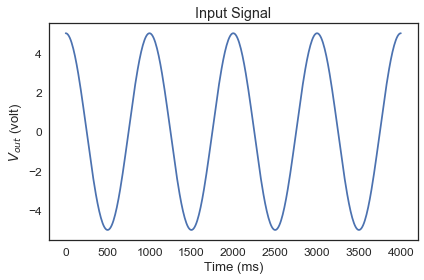

In [46]:
x = linspace(0, system1.t_end * 1000, 401)
v = A * np.cos(2 * pi * (f / 1000) * x)
plt.plot(x, v)
decorate(xlabel='Time (ms)',
             ylabel='$V_{out}$ (volt)',
             title='Input Signal',
             legend=False)

In [47]:
def slope_func_init(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)"""

    vout = state
    
    unpack(system)
    
    vin = A * np.cos(2 * pi * f * t)
    
    dvoutdt = (vin - vout) / (R * C)
    
    return dvoutdt

In [48]:
results1, details1 = run_ode_solver(system1, 
                                    slope_func_init, 
                                    t_eval=system1.ts)

In [49]:
def plot_results(results):
    xs = results.V_out.index
    ys = results.V_out.values

    t_end = get_last_label(results)
    if t_end < 10:
        xs *= 1000
        xlabel = 'Time (ms)'
    else:
        xlabel = 'Time (s)'
        
    plot(xs, ys)
    decorate(xlabel=xlabel,
             ylabel='$V_{out}$ (volt)',
             legend=False)

In [50]:
params2 = Params(
    R = 100e3,   # ohm
    C = 1e-6,  # farad
    vin = results1.V_out
)

,values
R,100000
C,1e-06
vin,0.00 0.000000 0.01 4.346388 0.02 4.89...


In [51]:
system2 = make_system(params2)

,values
R,100000
C,1e-06
A,5
f,1
init,V_out 0 dtype: int64
t_end,4
ts,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07..."
omega,6.28319
tau,0.1
cutoff,1.59155


In [52]:
def slope_func_high_pass(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    unpack(system)
    
    vin1 = A * np.cos(2 * pi * f * t)
    
    #vin = interpolate(system.vin)
    
    dvindt = (vin1 - vout) / (R * C)
    
    dvoutdt = dvindt - ((vout) / (R * C))
    
    return dvoutdt

In [53]:
def slope_func_low_pass(state, t, system):
    """Makes a slope function to update the state.
    
    state: State(V_out)
    t: time
    system: System Object
    
    returns: State(V_out)
    """
    vout = state
    
    #unpack(system)
    
    vin = interpolate(system.vin)
    
    dvoutdt = (vin(t) - vout) / (system.R * system.C)
    
    return dvoutdt

In [54]:
results2, details2 = run_ode_solver(system2, 
                                    slope_func_high_pass, 
                                    t_eval=system2.ts)

In [55]:
params3 = Params(
    R = 499,   # ohm
    C = 10e-6,  # farad
    vin = results2.V_out
)

,values
R,499
C,1e-05
vin,0.00 0.000000 0.01 0.452860 0.02 0.82...


In [56]:
system3 = make_system(params3)

,values
R,499
C,1e-05
A,5
f,1
init,V_out 0 dtype: int64
t_end,4
ts,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07..."
omega,6.28319
tau,0.00499
cutoff,31.8948


In [57]:
results3, details3 = run_ode_solver(system3, 
                                    slope_func_low_pass, 
                                    t_eval=system3.ts)

In [58]:
params4 = Params(
    R = 4.9e3,   # ohm
    C = 1e-6,  # farad
    vin = results3.V_out
)

,values
R,4900
C,1e-06
vin,0.00 0.000000 0.01 0.257302 0.02 0.63...


In [59]:
system4 = make_system(params4)

,values
R,4900
C,1e-06
A,5
f,1
init,V_out 0 dtype: int64
t_end,4
ts,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07..."
omega,6.28319
tau,0.0049
cutoff,32.4806


In [60]:
results4, details4 = run_ode_solver(system4, 
                                    slope_func_low_pass, 
                                    t_eval=system4.ts)

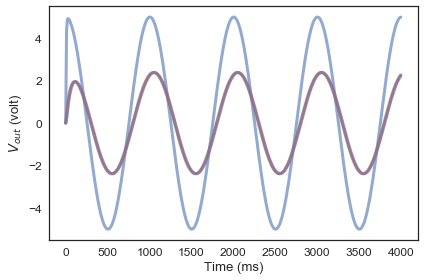

In [61]:
plot_results(results1)
plot_results(results2)
plot_results(results3)
plot_results(results4)

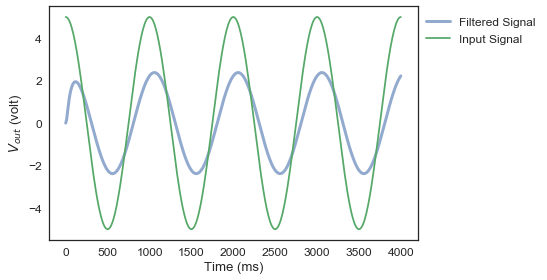

In [62]:
#plt.xkcd()
plot_results(results4)
plt.plot(x, v)
plt.legend(["Filtered Signal", "Input Signal"], 
           loc='upper right', bbox_to_anchor=(1.35, 1))

In [63]:
def amp(R):
    G = 1 + (100e3/R)
    return G

In [64]:
G1 = amp(2e3)
G2 = amp(4.9e3);

In [65]:
run_sim_system = System(R1 = 4.9e3, # ohm
                        C1 = 1e-6,  # farad 
                        A = 5 * G1, # volt
                        f = input_freq.f,   # Hz 
                        vin = 0, 
                        R2 = 100e3,   # ohm
                        C2 = 1e-6,  # farad
                        R3 = 499,   # ohm
                        C3 = 10e-6,  # farad
                        R4 = 4.9e3,   # ohm
                        C4 = 1e-6  # farad
                        )

,values
R1,4900.000000
C1,0.000001
A,255.000000
f,1.000000
vin,0.000000
R2,100000.000000
C2,0.000001
R3,499.000000
C3,0.000010
R4,4900.000000


In [66]:
def run_sim(input_freq, make_system, 
            slope_func_init, slope_func_high_pass, 
            slope_func_low_pass, G1, G2, system):
    
    params5 = Params(
    R = system.R1,   
    C = system.C1,  
    A = system.A,      
    f = system.f,   
    vin = system.vin
    )
    
    system5 = make_system(params5)
    results5, details5 = run_ode_solver(system5, 
                                        slope_func_init, 
                                        t_eval=system5.ts)
    
    params6 = Params(
    R = system.R2,
    C = system.C2,
    vin = results5.V_out
    )
    
    system6 = make_system(params6)
    results6, details6 = run_ode_solver(system6, 
                                        slope_func_high_pass, 
                                        t_eval=system6.ts)
    
    params7 = Params(
    R = system.R3,
    C = system.C3,
    vin = results6.V_out * G2
    )
    
    system7 = make_system(params7)
    results7, details7 = run_ode_solver(system7, 
                                        slope_func_low_pass, 
                                        t_eval=system7.ts)
    
    params8 = Params(
    R = system.R4,
    C = system.C4,
    vin = results7.V_out
    )
    
    system8 = make_system(params8)
    results8, details8 = run_ode_solver(system8, 
                                        slope_func_low_pass, 
                                        t_eval=system8.ts)
    
    A_in = params5.A
    
    A_out=(results8.V_out.max()-results8.V_out.min())/2
        
    ratio = A_out/A_in
    
    return State(results5=results5, 
                 results6=results6, 
                 result7=results7, 
                 results8=results8, 
                 ratio=ratio)

In [67]:
input_freq.f = 50

In [68]:
results5, results6, results7, results8, ratio = run_sim(input_freq, 
                                                        make_system, 
                                                        slope_func_init, 
                                                        slope_func_high_pass, 
                                                        slope_func_low_pass, 
                                                        G1, G2, run_sim_system)

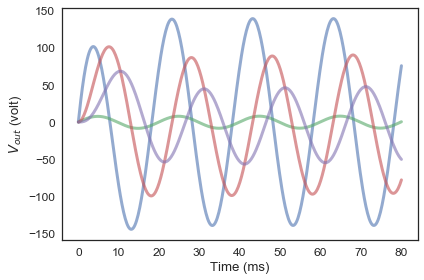

In [69]:
plot_results(results5)
plot_results(results6)
plot_results(results7)
plot_results(results8)

In [70]:
sweep = SweepSeries()
for f in linspace(1, 100, 50):
    input_freq.f=f
    state = run_sim(input_freq, make_system, 
                    slope_func_init, 
                    slope_func_high_pass, 
                    slope_func_low_pass, 
                    G1, G2, run_sim_system).ratio
    sweep[f] = state;

1      10.197651
3       7.765590
5       5.721766
7       4.360892
9       3.436437
11      2.777009
13      2.286031
15      1.910413
17      1.614331
19      1.375114
21      1.180210
23      1.019132
25      0.883861
27      0.770262
29      0.683819
31      0.609985
33      0.546003
35      0.490474
37      0.441881
39      0.399260
41      0.361922
43      0.328699
45      0.301777
47      0.276901
49      0.254763
51      0.235084
53      0.217114
55      0.201070
57      0.186681
59      0.173584
61      0.161632
63      0.152690
65      0.140752
67      0.131721
69      0.123395
71      0.115944
73      0.108831
75      0.102378
77      0.096689
79      0.091285
81      0.086353
83      0.081716
85      0.077447
87      0.073453
89      0.069748
91      0.066270
93      0.063024
95      0.059960
97      0.057083
100     0.053145
dtype: float64


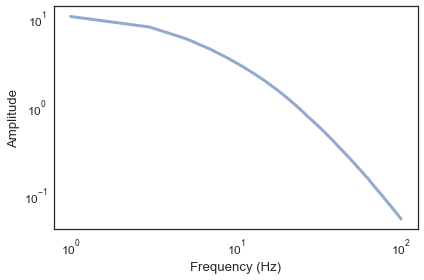

In [71]:
plot(sweep)
decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             xscale='log',
             yscale='log')

print(sweep)

In [72]:
from pandas import read_csv
data = read_csv("Bode Plot Data Two Channel Adjusted.csv")
data.columns = ["Frequency", "Channel1", "Channel2"]
print(data)

    Frequency  Channel1   Channel2
0    1.204622  1.336704   7.892721
1    1.394753  2.062281   7.447578
2    1.614894  2.720442   6.957306
3    1.869782  3.309978   6.506548
4    2.164899  3.832494   6.041254
5    2.506597  4.289950   5.543557
6    2.902226  4.685360   5.103302
7    3.360299  5.021772   4.687570
8    3.890673  5.305573   4.287470
9    4.504759  5.534682   3.906275
10   5.215768  5.710039   3.533519
11   6.039000  5.834386   3.155440
12   6.992167  5.909790   2.756838
13   8.095778  5.936137   2.324386
14   9.373577  5.912632   1.843787
15  10.853058  5.834932   1.306494
16  12.566053  5.702385   0.701586
17  14.549419  5.513495   0.023472
18  16.845831  5.264004  -0.726697
19  19.504696  4.946740  -1.541431
20  22.583225  4.554394  -2.408142
21  26.147654  4.080540  -3.317242
22  30.274676  3.520765  -4.257796
23  35.053087  2.875092  -5.225047
24  40.585699  2.145339  -6.203025
25  46.991553  1.336644  -7.194759
26  54.408477  0.455705  -8.204307
27  62.996052 -0.488

In [73]:
def plot_data(data):
    f = (data.Frequency)
    a = (data.Channel2)
       
    plot(f, a)
    decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             xscale='log',
             yscale='log',
             title='Bode Plot Collected Data',
             legend=False)

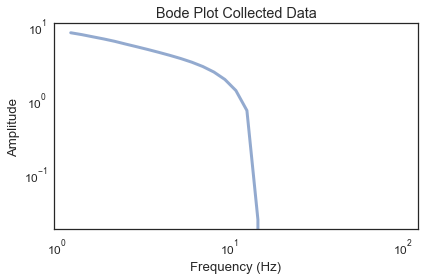

In [74]:
plot_data(data)

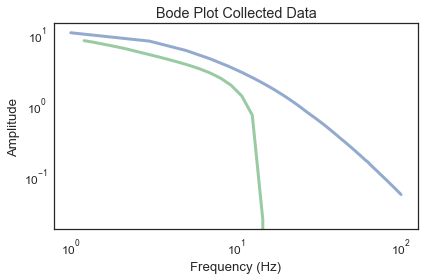

In [75]:
plot(sweep)
decorate(xlabel='Frequency (Hz)',
             ylabel='Amplitude',
             title='Bode Plot Simulated VS Collected Data')
plot_data(data)

In [76]:
input_freq.f = 1

In [77]:
example_system = make_system(params1)

,values
R,4900
C,1e-06
A,5
f,1
init,V_out 0 dtype: int64
t_end,4
ts,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07..."
omega,6.28319
tau,0.0049
cutoff,32.4806


In [78]:
example_results1, exmpale_details1 = run_ode_solver(example_system, 
                                                    slope_func_high_pass, 
                                                    t_eval=example_system.ts)

In [79]:
example_results2, exmaple_details2 = run_ode_solver(example_system, 
                                                    slope_func_init, 
                                                    t_eval=example_system.ts)

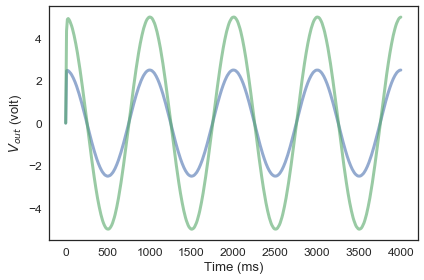

In [80]:
plot_results(example_results1)
plot_results(example_results2)